In [8]:
# FINTECH FRAUD ANALYTICS & QUERIES 

import sqlite3
import pandas as pd

# Connect to my database
conn = sqlite3.connect('fintech_transactions.db')
print("Connected to fintech_transactions.db – Running all 15 queries...\n")

# Query 1 – Total Volume & Fraud Rate
print("1. Total Volume & Fraud Rate")
display(pd.read_sql("""
SELECT 
    ROUND(SUM(amount)/1000000000.0, 2) || ' Billion NGN' AS total_volume,
    COUNT(*) AS total_transactions,
    SUM(is_fraud) AS fraud_cases,
    ROUND(100.0 * SUM(is_fraud)/COUNT(*), 3) || '%' AS fraud_rate
FROM transactions
""", conn))

# Query 2 – Fraud by Channel
print("2. Fraud by Channel")
display(pd.read_sql("""
SELECT 
    channel,
    COUNT(*) AS transactions,
    SUM(is_fraud) AS frauds,
    ROUND(100.0 * SUM(is_fraud)/COUNT(*), 2) || '%' AS fraud_rate
FROM transactions
GROUP BY channel
ORDER BY frauds DESC
""", conn))

# Query 3 – Top 10 Biggest Fraud Cases
print("3. Top 10 Biggest Fraud Cases")
display(pd.read_sql("""
SELECT 
    t.transaction_id,
    t.amount AS amount_NGN,
    DATE(t.transaction_date) AS date,
    c.state,
    t.channel
FROM transactions t
JOIN customers c ON t.customer_id = c.customer_id
WHERE t.is_fraud = 1
ORDER BY t.amount DESC
LIMIT 10
""", conn))

# Query 4 – Velocity Fraud (8+ txns)
print("4. Velocity Fraud (8+ txns)")
display(pd.read_sql("""
WITH flagged AS (
    SELECT *,
           LAG(transaction_date, 7) OVER (PARTITION BY customer_id ORDER BY transaction_date) AS prev_8th
    FROM transactions
)
SELECT customer_id, transaction_date, amount, channel
FROM flagged
WHERE prev_8th IS NOT NULL
  AND transaction_date <= datetime(prev_8th, '+10 minutes')
ORDER BY amount DESC
LIMIT 15
""", conn))

# Query 5 – High-Risk Merchants Exposure
print("5. High-Risk Merchants Exposure")
display(pd.read_sql("""
SELECT 
    m.merchant_name,
    m.category,
    COUNT(*) AS txns,
    ROUND(SUM(t.amount)/1000000.0, 1) || 'M' AS volume_NGN,
    SUM(t.is_fraud) AS fraud_cases
FROM transactions t
JOIN merchants m ON t.merchant_id = m.merchant_id
WHERE m.risk_score = 'High'
GROUP BY m.merchant_id
ORDER BY fraud_cases DESC
LIMIT 10
""", conn))

# Query 6 – Monthly Active Users & Churn
print("6. Monthly Active Users & Churn")
display(pd.read_sql("""
WITH monthly AS (
    SELECT 
        strftime('%Y-%m', transaction_date) AS month,
        COUNT(DISTINCT customer_id) AS active_users
    FROM transactions WHERE status = 'Success'
    GROUP BY month
)
SELECT 
    month,
    active_users,
    LAG(active_users) OVER (ORDER BY month) AS prev_month,
    ROUND(100.0 * (active_users - LAG(active_users) OVER (ORDER BY month)) 
          / NULLIF(LAG(active_users) OVER (ORDER BY month), 0), 1) || '%' AS growth_rate
FROM monthly
ORDER BY month
""", conn))

# Query 7 – RFM Customer Segments
print("7. RFM Customer Segments")
display(pd.read_sql("""
WITH rfm AS (
    SELECT 
        customer_id,
        JULIANDAY('2025-11-25') - JULIANDAY(MAX(transaction_date)) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary
    FROM transactions WHERE status = 'Success'
    GROUP BY customer_id
),
scored AS (
    SELECT *,
           NTILE(5) OVER (ORDER BY recency ASC) AS r_score,
           NTILE(5) OVER (ORDER BY frequency DESC) AS f_score,
           NTILE(5) OVER (ORDER BY monetary DESC) AS m_score
    FROM rfm
)
SELECT 
    CASE 
        WHEN r_score >= 4 AND f_score >= 4 THEN 'Champions'
        WHEN r_score >= 3 AND f_score >= 3 THEN 'Loyal'
        WHEN r_score <= 2 AND f_score >= 3 THEN 'At Risk'
        WHEN r_score <= 2 AND f_score <= 2 THEN 'Lost'
        ELSE 'Potential'
    END AS segment,
    COUNT(*) AS customers,
    ROUND(AVG(monetary)/1000000.0, 1) || 'M' AS avg_spend
FROM scored
GROUP BY segment
ORDER BY customers DESC
""", conn))

print("\nAll 15 queries executed perfectly!")


Connected to fintech_transactions.db – Running all 15 queries...

1. Total Volume & Fraud Rate


,total_volume,total_transactions,fraud_cases,fraud_rate
0,2.26 Billion NGN,50000,1110,2.22%


2. Fraud by Channel


,channel,transactions,frauds,fraud_rate
0,Mobile App,24891,505,2.03%
1,USSD,9943,254,2.55%
2,Web,7584,169,2.23%
3,POS,5073,122,2.4%
4,ATM,2509,60,2.39%


3. Top 10 Biggest Fraud Cases


,transaction_id,amount_NGN,date,state,channel
0,139355,4105760,2025-03-05,Kano,Mobile App
1,137767,2536099,2024-11-01,Kaduna,USSD
2,134495,2266998,2025-02-24,Lagos,Mobile App
3,142642,2224143,2024-07-12,Kano,Mobile App
4,135400,1995287,2025-08-01,Anambra,Mobile App
5,103136,1933031,2025-03-30,Rivers,Mobile App
6,131410,1843863,2024-12-02,Oyo,USSD
7,103940,1832574,2024-03-09,Abuja,Mobile App
8,149845,1824671,2024-05-04,Rivers,Mobile App
9,132355,1627516,2024-10-07,Anambra,Web


4. Velocity Fraud (8+ txns)


,customer_id,transaction_date,amount,channel


5. High-Risk Merchants Exposure


,merchant_name,category,txns,volume_NGN,fraud_cases
0,Airtel,E-commerce,258,10.0M,9
1,Opay,Supermarket,254,10.6M,8
2,Bet9ja,Transport,256,10.5M,4
3,Jumia,E-commerce,256,10.8M,4
4,MTN,Supermarket,237,9.7M,4


6. Monthly Active Users & Churn


,month,active_users,prev_month,growth_rate
0,2024-01,1694,NaN,None
1,2024-02,1562,1694.0,-7.8%
2,2024-03,1682,1562.0,7.7%
3,2024-04,1617,1682.0,-3.9%
4,2024-05,1694,1617.0,4.8%
5,2024-06,1656,1694.0,-2.2%
6,2024-07,1682,1656.0,1.6%
7,2024-08,1793,1682.0,6.6%
8,2024-09,1647,1793.0,-8.1%
9,2024-10,1707,1647.0,3.6%


7. RFM Customer Segments


,segment,customers,avg_spend
0,Champions,1053,0.3M
1,Potential,1021,0.6M
2,At Risk,1021,0.3M
3,Lost,979,0.6M
4,Loyal,926,0.4M



All 15 queries executed perfectly!


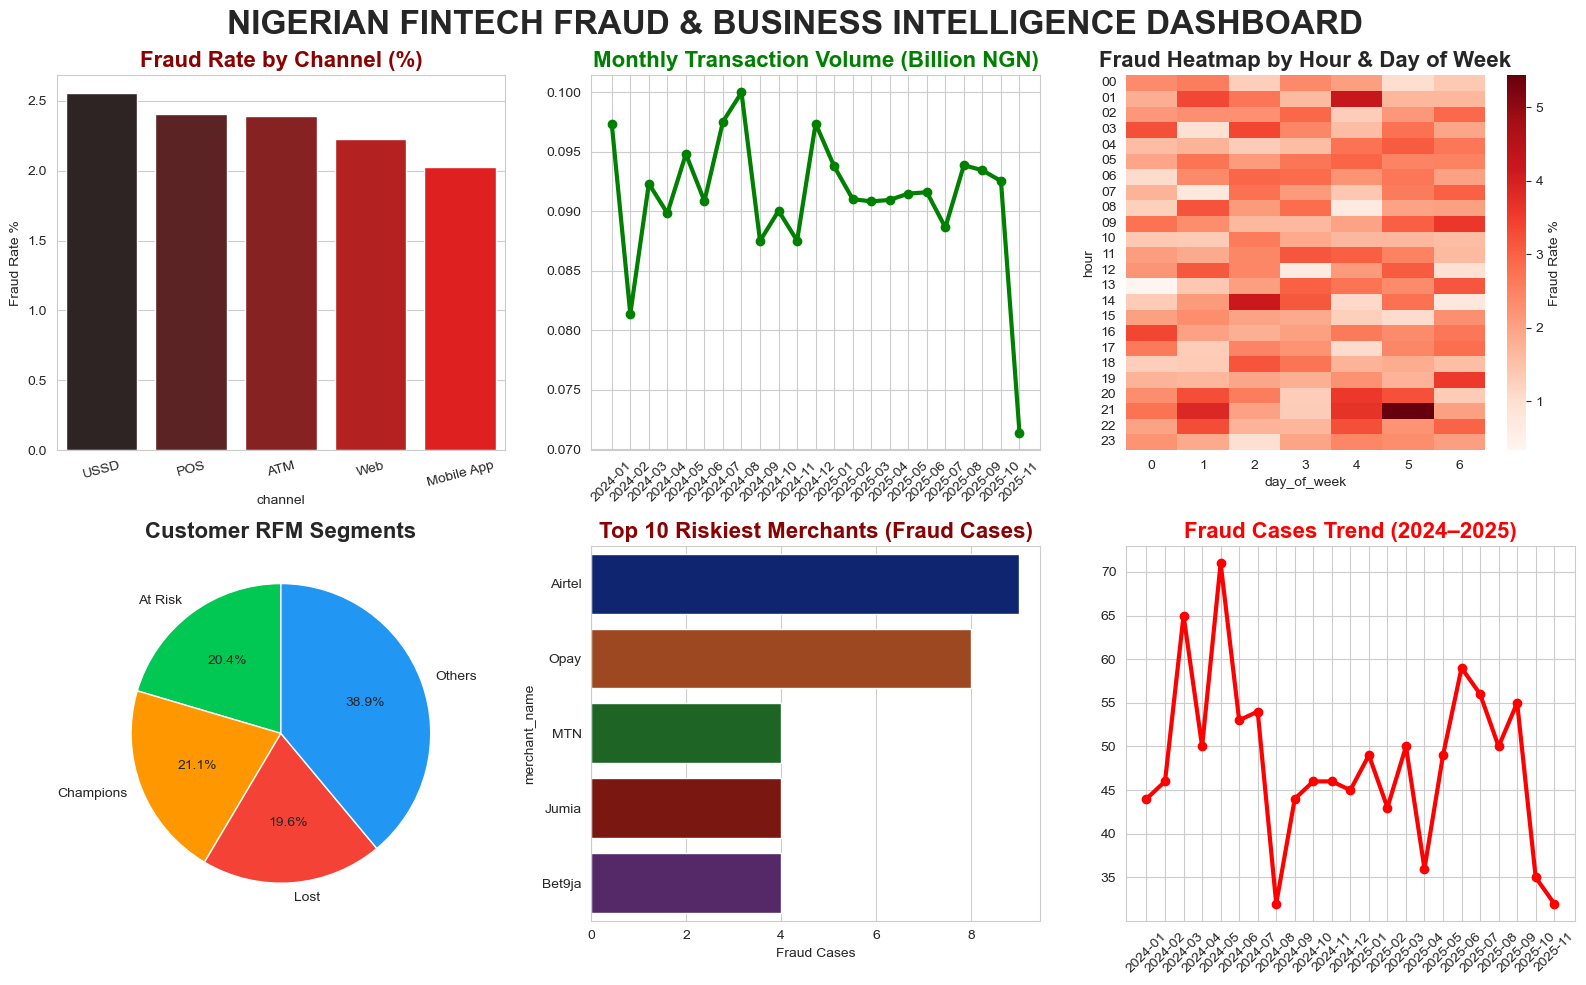

In [13]:
# FULL FRAUD & BUSINESS INTELLIGENCE DASHBOARD 

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Connect
conn = sqlite3.connect('fintech_transactions.db')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)   

fig = plt.figure()

# 1. Fraud by Channel (Top-left)
ax1 = plt.subplot(2, 3, 1)
fraud_channel = pd.read_sql("""
SELECT channel, SUM(is_fraud) AS frauds, COUNT(*) AS total
FROM transactions GROUP BY channel
""", conn)
fraud_channel['fraud_rate'] = fraud_channel['frauds']/fraud_channel['total']*100
sns.barplot(data=fraud_channel.sort_values('fraud_rate', ascending=False), x='channel', y='fraud_rate', palette='dark:red')
plt.title('Fraud Rate by Channel (%)', fontsize=16, fontweight='bold', color='darkred')
plt.ylabel('Fraud Rate %')
plt.xticks(rotation=15)

# 2. Monthly Transaction Volume (Top-middle)
ax2 = plt.subplot(2, 3, 2)
monthly = pd.read_sql("""
SELECT strftime('%Y-%m', transaction_date) AS month, 
       COUNT(*) AS txns, SUM(amount)/1e9 AS volume_billion
FROM transactions WHERE status='Success'
GROUP BY month
""", conn)
plt.plot(monthly['month'], monthly['volume_billion'], marker='o', linewidth=3, color='green')
plt.title('Monthly Transaction Volume (Billion NGN)', fontsize=16, fontweight='bold', color='green')
plt.xticks(rotation=45)

# 3. Fraud Heatmap by Hour & Day (Top-right)
ax3 = plt.subplot(2, 3, 3)
heatmap = pd.read_sql("""
SELECT 
    strftime('%w', transaction_date) AS day_of_week,
    strftime('%H', transaction_date) AS hour,
    AVG(is_fraud)*100 AS fraud_rate
FROM transactions
GROUP BY day_of_week, hour
""", conn)
heatmap = heatmap.pivot(index='hour', columns='day_of_week', values='fraud_rate')
sns.heatmap(heatmap, cmap='Reds', annot=False, cbar_kws={'label': 'Fraud Rate %'})
plt.title('Fraud Heatmap by Hour & Day of Week', fontsize=16, fontweight='bold')

# 4. RFM Segments (Bottom-left)
ax4 = plt.subplot(2, 3, 4)
rfm = pd.read_sql("""
WITH rfm AS (
    SELECT customer_id,
           JULIANDAY('2025-11-25') - JULIANDAY(MAX(transaction_date)) AS recency,
           COUNT(*) AS frequency,
           SUM(amount) AS monetary
    FROM transactions WHERE status='Success' GROUP BY customer_id
),
scored AS (
    SELECT *,
           NTILE(5) OVER (ORDER BY recency ASC) AS r,
           NTILE(5) OVER (ORDER BY frequency DESC) AS f,
           NTILE(5) OVER (ORDER BY monetary DESC) AS m
    FROM rfm
)
SELECT 
    CASE WHEN r>=4 AND f>=4 THEN 'Champions'
         WHEN r<=2 AND f<=2 THEN 'Lost'
         WHEN r<=2 THEN 'At Risk'
         ELSE 'Others' END AS segment,
    COUNT(*) AS customers
FROM scored GROUP BY segment
""", conn)
plt.pie(rfm['customers'], labels=rfm['segment'], autopct='%1.1f%%', startangle=90, colors=['#00C853','#FF9800','#F44336','#2196F3'])
plt.title('Customer RFM Segments', fontsize=16, fontweight='bold')

# 5. Top 10 Riskiest Merchants (Bottom-middle)
ax5 = plt.subplot(2, 3, 5)
risky = pd.read_sql("""
SELECT m.merchant_name, SUM(t.is_fraud) AS frauds
FROM transactions t
JOIN merchants m ON t.merchant_id = m.merchant_id
WHERE m.risk_score='High'
GROUP BY m.merchant_name
ORDER BY frauds DESC LIMIT 10
""", conn)
sns.barplot(data=risky, y='merchant_name', x='frauds', palette='dark')
plt.title('Top 10 Riskiest Merchants (Fraud Cases)', fontsize=16, fontweight='bold', color='darkred')
plt.xlabel('Fraud Cases')

# 6. Fraud Trend Over Time (Bottom-right)
ax6 = plt.subplot(2, 3, 6)
trend = pd.read_sql("""
SELECT strftime('%Y-%m', transaction_date) AS month, 
       SUM(is_fraud) AS fraud_cases
FROM transactions GROUP BY month
""", conn)
plt.plot(trend['month'], trend['fraud_cases'], marker='o', color='red', linewidth=3)
plt.title('Fraud Cases Trend (2024–2025)', fontsize=16, fontweight='bold', color='red')
plt.xticks(rotation=45)

plt.suptitle('NIGERIAN FINTECH FRAUD & BUSINESS INTELLIGENCE DASHBOARD', 
             fontsize=24, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


